In [1]:
# Standard Library Imports
import pickle
import gzip
import math
import os
import time
import shutil
import sys
import gc
import traceback
from pathlib import Path
from operator import attrgetter, itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

# Third-Party Library Imports
import torch
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from datasets import load_dataset, load_dataset_builder
from torcheval.metrics import MulticlassAccuracy
import fastcore.all as fc

# PyTorch
from torch import tensor, nn, optim
from torch.utils.data import DataLoader, default_collate
from torch.nn import init
import torch.nn.functional as F

# miniai
from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *

# Fastcore
from fastcore.test import test_close

# PyTorch settings
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

# Disable logging warnings
import logging
logging.disable(logging.WARNING)

set_seed(42)

In [2]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [TF.to_tensor(o) for o in b[xl]]

bs = 1024
tds = dsd.with_transform(transformi)

dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))

In [3]:
def get_model():
    return nn.Sequential(conv(1 ,8), conv(8 ,16), conv(16,32), conv(32,64),
                         conv(64,10, act=False), nn.Flatten()).to(def_device)

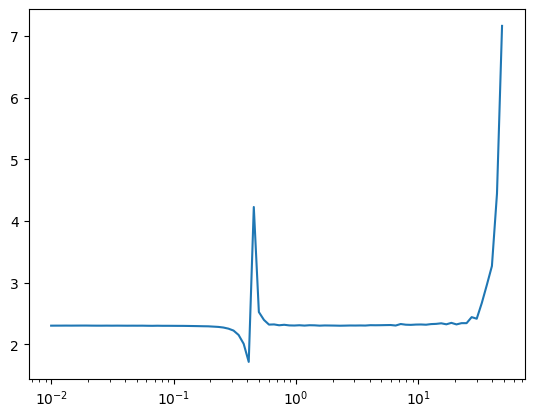

In [4]:
MomentumLearner(get_model(), dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find(gamma=1.1, start_lr=1e-2)

In [5]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(nn.ReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]

learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)

accuracy,loss,epoch,train
0.228,2.087,0,train
0.468,1.416,0,eval


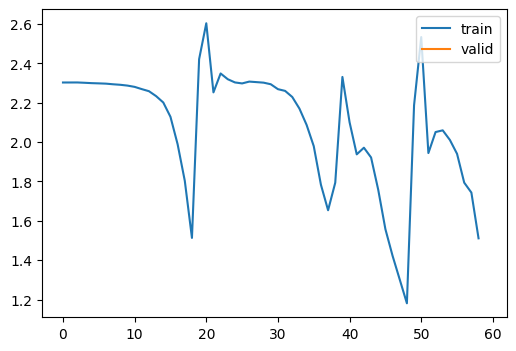

In [6]:
learn.fit(1)

In [7]:
def clean_ipython_hist():
    # Code in this function mainly copied from IPython source
    if not 'get_ipython' in globals(): return
    ip = get_ipython()
    user_ns = ip.user_ns
    ip.displayhook.flush()
    pc = ip.displayhook.prompt_count + 1
    for n in range(1, pc): user_ns.pop('_i'+repr(n),None)
    user_ns.update(dict(_i='',_ii='',_iii=''))
    hm = ip.history_manager
    hm.input_hist_parsed[:] = [''] * pc
    hm.input_hist_raw[:] = [''] * pc
    hm._i = hm._ii = hm._iii = hm._i00 =  ''

In [8]:
def clean_tb():
    # h/t Piotr Czapla
    if hasattr(sys, 'last_traceback'):
        traceback.clear_frames(sys.last_traceback)
        delattr(sys, 'last_traceback')
    if hasattr(sys, 'last_type'): delattr(sys, 'last_type')
    if hasattr(sys, 'last_value'): delattr(sys, 'last_value')

In [9]:
def clean_mem():
    clean_tb()
    clean_ipython_hist()
    gc.collect()
    torch.cuda.empty_cache()

In [10]:
x = torch.randn(200, 100)

for i in range(50):
    x = x @ torch.randn(100,100)

x[0:5,0:5]

tensor([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]])

In [11]:
x = torch.randn(200, 100)

for i in range(50):
    x = x @ (torch.randn(100,100) * 0.01)

x[0:5,0:5]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [12]:
x = torch.randn(200, 100)

for i in range(50):
    x = x @ (torch.randn(100,100) * 0.1)

x[0:5,0:5]

tensor([[ 1.33, -1.54,  0.54,  0.13,  3.51],
        [ 0.20,  0.95,  0.61, -0.02,  1.73],
        [-0.69,  1.72,  0.36, -0.64, -2.40],
        [ 0.03,  0.73,  0.40, -1.24, -0.64],
        [ 0.33, -0.33,  0.03, -0.32,  0.62]])

In [13]:
x = torch.randn(200, 100)
y = torch.randn(200)

In [14]:
from math import sqrt

w1 = torch.randn(100,50) / sqrt(100)
b1 = torch.zeros(50)
w2 = torch.randn(50,1) / sqrt(50)
b2 = torch.zeros(1)

In [15]:
def lin(x, w, b):
    return x @ w + b

In [16]:
l1 = lin(x, w1, b1)
l1.mean(), l1.std()

(tensor(0.00), tensor(1.01))

In [17]:
def relu(x):
    return x.clamp_min(0.)

In [18]:
l2 = relu(l1)
l2.mean(), l2.std()

(tensor(0.40), tensor(0.59))

In [19]:
x = torch.randn(200, 100)

for i in range(50):
    x = relu(x @ (torch.randn(100,100) * 0.1))

x[0:5,0:5]

tensor([[    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00]])

In [20]:
x = torch.randn(200, 100)

for i in range(50):
    x = relu(x @ (torch.randn(100,100) * sqrt(2/100)))

x[0:5,0:5]

tensor([[0.00, 1.33, 0.56, 0.00, 0.76],
        [0.00, 0.77, 0.37, 0.00, 0.40],
        [0.00, 0.80, 0.24, 0.00, 0.45],
        [0.00, 0.67, 0.22, 0.00, 0.49],
        [0.00, 0.41, 0.17, 0.00, 0.27]])